In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import dask.distributed
from sklearn.metrics import r2_score

from multiprocessing import Pool, cpu_count
from fbprophet import Prophet
import ray

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

c = dask.distributed.Client() # Using this for parallel programming, to make quicker predictions

In [2]:
# !pip install pmdarima
NUM_CPU = 8
ray.init(
  # avoid error messages in case re-running this cell
   ignore_reinit_error=True
#   num_cpus = NUM_CPU
)

{'node_ip_address': '172.19.2.2',
 'raylet_ip_address': '172.19.2.2',
 'redis_address': '172.19.2.2:6379',
 'object_store_address': '/tmp/ray/session_2021-12-16_18-23-45_202968_20/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-16_18-23-45_202968_20/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-12-16_18-23-45_202968_20',
 'metrics_export_port': 50056,
 'node_id': '96dd3497598ccddfa7f5940969efe88cfd685cbe46503396546450bd'}

In [3]:
import warnings as wg
wg.filterwarnings("ignore")

In [4]:
df = pd.read_csv("../input/zenatix/AC_Data.csv")

In [5]:
df.head(4)

,0,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
0,2019-08-01 00:00:00,7.518632,8.788315,0.0,0.0,2.617045,4.079041,2.782276,4.624447,5.222060,2.151238,1.585072,0.560373,3.142941,2.749470,5.417774,4.113460,3.305072,6.735981
1,2019-08-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-08-01 00:02:00,7.426114,8.940615,0.0,0.0,2.581625,3.781231,2.529366,5.057423,5.349465,2.414715,2.168184,1.818730,3.085110,2.720484,3.302422,3.986483,3.220588,6.379500
3,2019-08-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
np.max(np.array(df.dropna().drop("0", axis = "columns")))

11.1947890625

In [7]:
np.min(np.array(df.dropna().drop("0", axis = "columns")))

0.0

**We have only 50% of the data, of alternate minutes only**

In [8]:
df = df.reset_index()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87840 entries, 0 to 87839
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   87840 non-null  int64  
 1   0       87840 non-null  object 
 2   AC 1    43708 non-null  float64
 3   AC 2    43711 non-null  float64
 4   AC 3    43713 non-null  float64
 5   AC 4    43704 non-null  float64
 6   AC 5    43716 non-null  float64
 7   AC 6    43717 non-null  float64
 8   AC 7    43679 non-null  float64
 9   AC 8    43704 non-null  float64
 10  AC 9    43654 non-null  float64
 11  AC 10   43690 non-null  float64
 12  AC 11   43670 non-null  float64
 13  AC 12   43713 non-null  float64
 14  AC 13   43719 non-null  float64
 15  AC 14   43696 non-null  float64
 16  AC 15   43715 non-null  float64
 17  AC 16   43710 non-null  float64
 18  AC 17   43714 non-null  float64
 19  AC 18   43723 non-null  float64
dtypes: float64(18), int64(1), object(1)
memory usage: 13.4+ MB


**0 column is in the form of a string, so convert it to datetime datatype**

In [10]:
df["0"] = df["0"].astype("datetime64")

In [11]:
df.shape

(87840, 20)

In [12]:
df.isna().sum() / df.shape[0] *100

index     0.000000
0         0.000000
AC 1     50.241348
AC 2     50.237933
AC 3     50.235656
AC 4     50.245902
AC 5     50.232240
AC 6     50.231102
AC 7     50.274362
AC 8     50.245902
AC 9     50.302823
AC 10    50.261840
AC 11    50.284608
AC 12    50.235656
AC 13    50.228825
AC 14    50.255009
AC 15    50.233379
AC 16    50.239071
AC 17    50.234517
AC 18    50.224271
dtype: float64

In [13]:
df.tail(3)

,index,0,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
87837,87837,2019-09-30 23:57:00,1.209176,6.152532,2.211421,0.0,1.448103,0.000000,3.151248,2.871690,3.417942,2.185493,5.174168,2.772349,3.786657,2.060023,4.057525,1.870886,2.991946,7.134647
87838,87838,2019-09-30 23:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87839,87839,2019-09-30 23:59:00,1.430442,6.078281,1.891162,0.0,1.577491,4.364239,3.126339,3.287224,3.986978,2.013912,4.821829,3.363855,3.380110,1.949240,4.026304,1.862166,3.009434,7.179719


# Which AC had the highest total power consumption?

In [14]:
index = df.iloc[:,2:].sum(axis = 0).index
values = df.iloc[:,2:].sum(axis = 0).values

<BarContainer object of 18 artists>

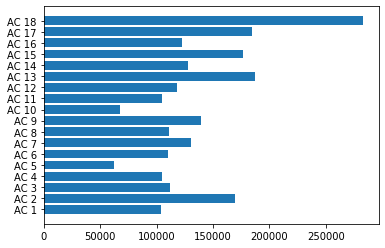

In [15]:
plt.barh(index, values)

**Overall Power Consumption of AC 18 is the highest**

# Which AC was used the most/least?
For how much time, a particular AC was working

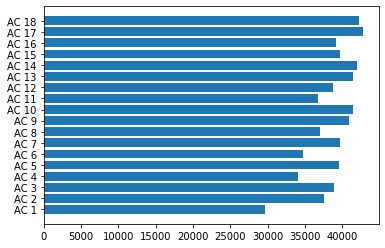

In [16]:
ac = df.iloc[:,2:][df.iloc[:,2:]>0].count().index
values = df.iloc[:,2:][df.iloc[:,2:]>0].count().values
# df[df>0].count()
plt.barh(ac, values)
plt.show()

**AC 1 has worked the least number of hours <br>
AC 17 has worked the most number of hours**

In [17]:
df.describe()

,index,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
count,87840.00000,43708.000000,43711.000000,43713.000000,43704.000000,43716.000000,43717.000000,43679.000000,43704.000000,43654.000000,43690.000000,43670.000000,43713.000000,43719.000000,43696.000000,43715.000000,43710.000000,43714.000000,43723.000000
mean,43919.50000,2.379368,3.868892,2.568411,2.395158,1.421699,2.518138,2.980883,2.548711,3.184382,1.538344,2.406141,2.699639,4.279893,2.917122,4.046283,2.800050,4.218979,6.462676
std,25357.36816,2.276782,2.545147,1.487508,1.797529,0.767218,1.655560,1.473498,1.504482,1.522291,0.685461,1.554481,1.436087,1.847168,1.454946,2.016898,1.606239,1.125491,2.319242
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21959.75000,0.000000,2.123263,1.706508,1.258299,0.970744,1.543779,2.190803,1.766230,2.294635,1.117139,1.591748,1.949729,3.260674,1.852981,3.023501,1.877626,3.752478,4.013579
50%,43919.50000,2.094330,3.791752,2.486992,2.308961,1.380183,2.665063,3.005071,2.608551,3.082134,1.504554,2.351361,2.727152,4.217381,2.787084,4.001279,2.673698,4.611434,7.131194
75%,65879.25000,3.661752,5.460892,3.441527,3.476123,1.870234,3.616988,3.897857,3.496358,4.096374,1.963707,3.254937,3.566744,5.379832,3.824467,5.260193,3.695294,4.958306,8.314639
max,87839.00000,11.194789,11.147141,8.430909,9.879500,5.495358,9.929291,9.356776,9.331506,10.026747,4.625030,10.363151,9.887306,9.796393,9.054969,10.349998,10.654430,5.950261,11.040031


In [18]:
# plt.plot(df["AC 1"])
# plt.ylim([0, 12])
# plt.show()

In [19]:
# df1 = df.copy()
# df1.dropna(inplace = True)

In [20]:
# plt.figure(figsize = (20, 10))
# plt.plot(df1["AC 1"][:1500])
# # plt.xticks(rotation=60)
# plt.ylim([0, 12])
# # plt.show()

In [21]:
# plt.figure(figsize = (20, 10))
# plt.plot(df1["AC 1"])
# # plt.xticks(rotation=60)
# plt.ylim([0, 12])
# plt.show()

In [22]:
# plt.figure(figsize = (20, 10))
# plt.plot(df["AC 1"].dropna())
# # plt.xticks(rotation=60)
# plt.ylim([0, 12])
# plt.show()

In [23]:
# plt.figure(figsize = (20, 10))
# plt.plot(df["AC 1"].bfill()[:3000])
# # plt.xticks(rotation=60)
# plt.ylim([0, 12])
# plt.show()

In [24]:
cols = list(df.columns) # gettting the list of columns of the dataframe
cols.remove("0")

In [25]:
cols

['index',
 'AC 1',
 'AC 2',
 'AC 3',
 'AC 4',
 'AC 5',
 'AC 6',
 'AC 7',
 'AC 8',
 'AC 9',
 'AC 10',
 'AC 11',
 'AC 12',
 'AC 13',
 'AC 14',
 'AC 15',
 'AC 16',
 'AC 17',
 'AC 18']

In [26]:
from sklearn.preprocessing import StandardScaler 
#Doing standardisation of the dataset, before filling missing values
scaler = StandardScaler().fit(df[cols])

In [27]:
df_scaled = pd.DataFrame(scaler.transform(df[cols]), columns = cols)

**I have used Gaussian Process Regressor to fill all the missing values, as AC power consumption depends on the outside temperature and temperature is a natural phenomenan, so it will follow Gaussian distribution, that's why using Gaussian process to fill the missing values.**

Reference:- [Click here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [29]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [30]:
df_scaled.head()

,index,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
0,-1.732031,2.257274,1.932886,-1.726674,-1.332488,1.558043,0.942836,-0.134788,1.379717,1.338575,0.894145,-0.528201,-1.489665,-0.615518,-0.115231,0.680008,0.817702,-0.812017,0.117844
1,-1.731992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.731952,2.216639,1.992726,-1.726674,-1.332488,1.511877,0.762949,-0.306429,1.667512,1.422270,1.278530,-0.153080,-0.613416,-0.646826,-0.135153,-0.368818,0.738649,-0.887082,-0.035864
3,-1.731913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.731873,2.052753,2.079357,-1.726674,-1.332488,1.525524,0.774363,-0.440168,2.508407,0.532762,1.019429,0.604377,-0.271038,-0.621008,-0.165136,-0.251506,0.621229,-0.966184,-0.042773


# Filling all the missing values using Gaussian Process regression

In [31]:
# Since, the alternate valuse are msising so I have used this function to create the final filled column
# By joining the predictions and already filled values alternately
def alternateMerge(arr1, arr2, n1, n2, arr3) :
    i = 0; j = 0; k = 0
 
    # Traverse both array
    while (i < n1 and j < n2) :
        arr3[k] = arr1[i]
        i += 1
        k += 1
         
        arr3[k] = arr2[j]
        j += 1
        k += 1
     
 
    # Store remaining elements of first array
    while (i < n1) :
        arr3[k] = arr1[i]
        i += 1
        k += 1
 
    # Store remaining elements of second array
    while (j < n2) :
        arr3[k] = arr2[j]
        k += 1
        j += 1
         
    return arr3
# Driver code
# arr1 = [1, 3, 5, 7, 9, 11]
# n1 = len(arr1)
 
# arr2 = [2, 4, 6, 8]
# n2 = len(arr2)
 
# arr3= [0] *(n1 + n2)
# alternateMerge(arr1, arr2, n1, n2, arr3)

**This "filling" function will make the predictions using gaussian preocess for the missing values and will return an array containing all the values**

In [32]:
def filling(col): 
    y_train = np.atleast_2d(df_scaled.dropna()[col]).T   
#     y_train = scaler2.fit_transform(y_train)
    
    with joblib.parallel_backend('dask'):
        gp.fit(X_train[::10], y_train[::10])

    y_pred = gp.predict(X_test)
    
    train_len = y_train.shape[0]
    pred_len = y_pred.shape[0]
    final = [0] *(train_len + pred_len)
    return alternateMerge(y_train, y_pred, train_len, pred_len, final)
#     return np.vstack((np.array(y_train).flatten(),np.array(y_pred).flatten())).ravel('F')
#     return scaler2.inverse_transform(np.vstack((y_train,y_pred)).ravel('F'))

**The index 0 - 87839 will be the X_train and X_test for filled and missing values repectively as the data is taken every minute so considering "2019-08-01 00:00:00" as "0" and "2019-09-30 23:59:00" as 87839**

In [33]:
# X_test = np.atleast_2d(df_scaled[df_scaled.isnull().any(axis=1)]["index"]).T
# X_train = np.atleast_2d(df_scaled.dropna()["index"]).T
# # X_test = df_scaled[df_scaled.isnull().any(axis=1)][["index"]]
# # X_train = df_scaled.dropna()[["index"]]
# data = pd.DataFrame()
# # data["Timestamps"] = df_scaled["0"]


# for i in tqdm(cols[1:]):
#     column = filling(i)
#     print(len(column))
#     data[i] = column

In [34]:
# data.head()

In [35]:
# for i in cols[1:]:
#     data[i] = data[i].map(lambda a: a[0])

In [36]:
# data.shape

In [37]:
# df_scaled["AC 1"].dropna()

In [38]:
# data.shape

In [39]:
# data.describe()

In [40]:
# data.insert(0, "index", df_scaled["index"])

In [41]:
# data.head()

In [42]:
df.head(5)

,index,0,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
0,0,2019-08-01 00:00:00,7.518632,8.788315,0.0,0.0,2.617045,4.079041,2.782276,4.624447,5.222060,2.151238,1.585072,0.560373,3.142941,2.749470,5.417774,4.113460,3.305072,6.735981
1,1,2019-08-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-08-01 00:02:00,7.426114,8.940615,0.0,0.0,2.581625,3.781231,2.529366,5.057423,5.349465,2.414715,2.168184,1.818730,3.085110,2.720484,3.302422,3.986483,3.220588,6.379500
3,3,2019-08-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-08-01 00:04:00,7.052986,9.161103,0.0,0.0,2.592095,3.800127,2.332304,6.322521,3.995392,2.237114,3.345624,2.310409,3.132799,2.676861,3.539026,3.797881,3.131560,6.363475


**Doing inverse transformation of the standardisation to get the original values back**

In [43]:
# new_data = pd.DataFrame(scaler.inverse_transform(data), columns = data.columns)

In [44]:
# new_data.shape

In [45]:
# new_data.head(3)

In [46]:
# new_data.insert(1, "Timestamp", df["0"])

In [47]:
# new_data.head(3)

In [48]:
# new_data.shape

In [49]:
# new_data.to_csv("another_data.csv", index = False)

In [50]:
final = pd.read_csv("../input/complete/another_data.csv")

**Here is the glimpse of the final data after filling the missing values using Gaussian process <br>
We can also see here that some values are negative and power consumption can never be negative**

In [51]:
final.head()

,index,Timestamp,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
0,0.0,2019-08-01 00:00:00,7.518632,8.788315,0.000000,0.000000,2.617045,4.079041,2.782276,4.624447,5.222060,2.151238,1.585072,0.560373,3.142941,2.749470,5.417774,4.113460,3.305072,6.735981
1,1.0,2019-08-01 00:01:00,7.341986,8.869652,0.207528,-0.099235,2.593492,4.070208,2.765041,4.675383,5.170101,2.285380,1.553008,1.004822,3.356319,2.827610,5.451596,3.925502,3.399600,6.925839
2,2.0,2019-08-01 00:02:00,7.426114,8.940615,0.000000,0.000000,2.581625,3.781231,2.529366,5.057423,5.349465,2.414715,2.168184,1.818730,3.085110,2.720484,3.302422,3.986483,3.220588,6.379500
3,3.0,2019-08-01 00:03:00,7.141880,8.807515,0.441401,-0.079926,2.560526,4.065357,2.622586,4.715786,4.910319,2.522343,1.513539,1.591031,3.681013,3.058494,5.547122,3.728646,3.278150,7.050406
4,4.0,2019-08-01 00:04:00,7.052986,9.161103,0.000000,0.000000,2.592095,3.800127,2.332304,6.322521,3.995392,2.237114,3.345624,2.310409,3.132799,2.676861,3.539026,3.797881,3.131560,6.363475


In [52]:
timestamp = final["Timestamp"]

In [53]:
final.drop("index", axis = "columns", inplace = True) #index column is not required now

In [54]:
final.drop("Timestamp", axis = "columns", inplace = True)

In [55]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87840 entries, 0 to 87839
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AC 1    87840 non-null  float64
 1   AC 2    87840 non-null  float64
 2   AC 3    87840 non-null  float64
 3   AC 4    87840 non-null  float64
 4   AC 5    87840 non-null  float64
 5   AC 6    87840 non-null  float64
 6   AC 7    87840 non-null  float64
 7   AC 8    87840 non-null  float64
 8   AC 9    87840 non-null  float64
 9   AC 10   87840 non-null  float64
 10  AC 11   87840 non-null  float64
 11  AC 12   87840 non-null  float64
 12  AC 13   87840 non-null  float64
 13  AC 14   87840 non-null  float64
 14  AC 15   87840 non-null  float64
 15  AC 16   87840 non-null  float64
 16  AC 17   87840 non-null  float64
 17  AC 18   87840 non-null  float64
dtypes: float64(18)
memory usage: 12.1 MB


**Replacing the values that are lesser than 0 with 0 and those that are exceeding 11.2 with 11.2**

In [56]:
final[final < 0] = 0
final[final > 11.2] = 11.2

In [57]:
final.head()

,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
0,7.518632,8.788315,0.000000,0.0,2.617045,4.079041,2.782276,4.624447,5.222060,2.151238,1.585072,0.560373,3.142941,2.749470,5.417774,4.113460,3.305072,6.735981
1,7.341986,8.869652,0.207528,0.0,2.593492,4.070208,2.765041,4.675383,5.170101,2.285380,1.553008,1.004822,3.356319,2.827610,5.451596,3.925502,3.399600,6.925839
2,7.426114,8.940615,0.000000,0.0,2.581625,3.781231,2.529366,5.057423,5.349465,2.414715,2.168184,1.818730,3.085110,2.720484,3.302422,3.986483,3.220588,6.379500
3,7.141880,8.807515,0.441401,0.0,2.560526,4.065357,2.622586,4.715786,4.910319,2.522343,1.513539,1.591031,3.681013,3.058494,5.547122,3.728646,3.278150,7.050406
4,7.052986,9.161103,0.000000,0.0,2.592095,3.800127,2.332304,6.322521,3.995392,2.237114,3.345624,2.310409,3.132799,2.676861,3.539026,3.797881,3.131560,6.363475


In [58]:
final.tail()

,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
87835,2.511127,6.717162,1.875420,1.806481,1.691359,1.537162,3.448224,0.415653,4.227140,1.663694,4.742731,4.865262,3.757177,2.561536,3.555997,1.302808,3.397213,5.285881
87836,2.220658,6.678334,1.934516,1.420872,1.661772,1.270944,3.380934,0.869382,4.073246,1.788681,4.804962,4.486897,3.729119,2.486492,3.620131,1.428109,3.352481,5.742623
87837,1.881810,6.621599,2.019405,0.927907,1.601010,0.919178,3.306470,1.480881,3.857143,1.922387,4.918952,3.967353,3.723702,2.375458,3.736725,1.587883,3.271311,6.266642
87838,1.489072,6.531572,2.137494,0.327968,1.504748,0.459029,3.205437,2.284129,3.597314,2.078861,5.102618,3.301589,3.753524,2.230496,3.912781,1.777735,3.149855,6.866085
87839,1.046616,6.427182,2.303093,0.000000,1.369138,0.000000,3.087444,3.297879,3.273236,2.247546,5.360683,2.454531,3.825678,2.039394,4.159966,2.008315,2.980594,7.547807


In [59]:
final.insert(0, "Timestamp", timestamp)

In [60]:
final.head(2)

,Timestamp,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
0,2019-08-01 00:00:00,7.518632,8.788315,0.000000,0.0,2.617045,4.079041,2.782276,4.624447,5.222060,2.151238,1.585072,0.560373,3.142941,2.74947,5.417774,4.113460,3.305072,6.735981
1,2019-08-01 00:01:00,7.341986,8.869652,0.207528,0.0,2.593492,4.070208,2.765041,4.675383,5.170101,2.285380,1.553008,1.004822,3.356319,2.82761,5.451596,3.925502,3.399600,6.925839


In [61]:
final = final.set_index("Timestamp")

In [62]:
final.head(2)

,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
Timestamp,,,,,,,,,,,,,,,,,,
2019-08-01 00:00:00,7.518632,8.788315,0.000000,0.0,2.617045,4.079041,2.782276,4.624447,5.222060,2.151238,1.585072,0.560373,3.142941,2.74947,5.417774,4.113460,3.305072,6.735981
2019-08-01 00:01:00,7.341986,8.869652,0.207528,0.0,2.593492,4.070208,2.765041,4.675383,5.170101,2.285380,1.553008,1.004822,3.356319,2.82761,5.451596,3.925502,3.399600,6.925839


In [63]:
final.tail(2)

,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,AC 11,AC 12,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18
Timestamp,,,,,,,,,,,,,,,,,,
2019-09-30 23:58:00,1.489072,6.531572,2.137494,0.327968,1.504748,0.459029,3.205437,2.284129,3.597314,2.078861,5.102618,3.301589,3.753524,2.230496,3.912781,1.777735,3.149855,6.866085
2019-09-30 23:59:00,1.046616,6.427182,2.303093,0.000000,1.369138,0.000000,3.087444,3.297879,3.273236,2.247546,5.360683,2.454531,3.825678,2.039394,4.159966,2.008315,2.980594,7.547807


# PACF and ACF

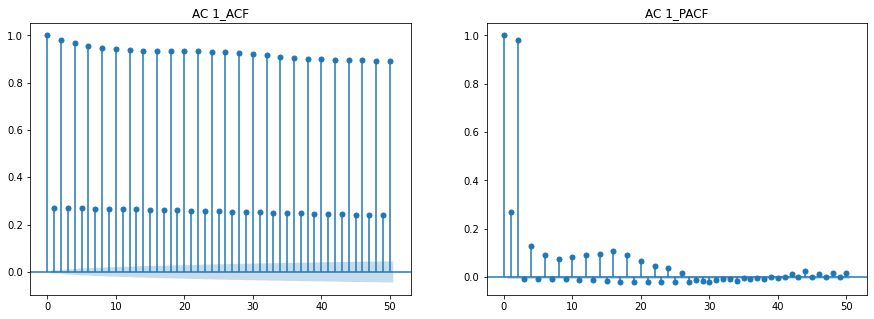

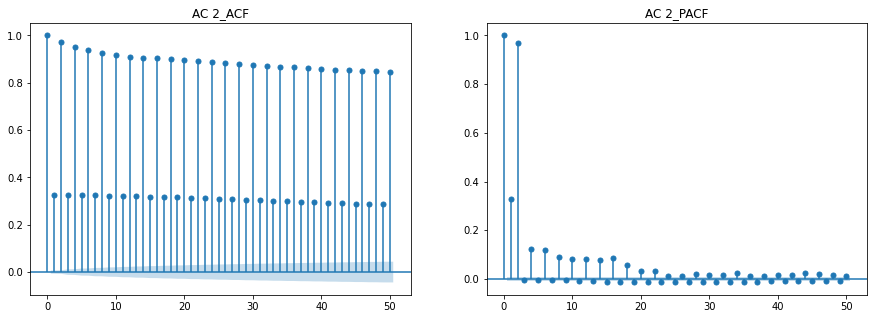

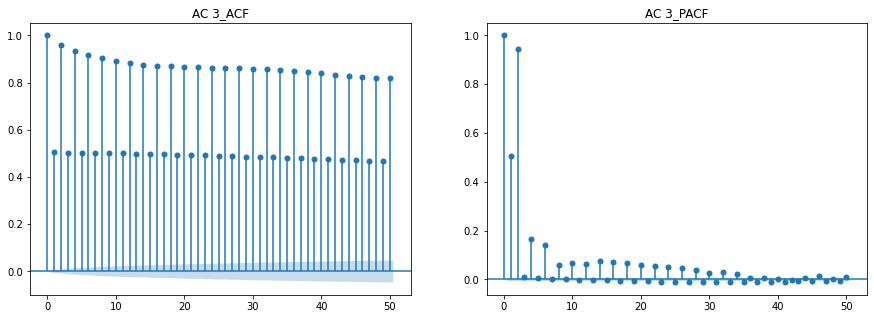

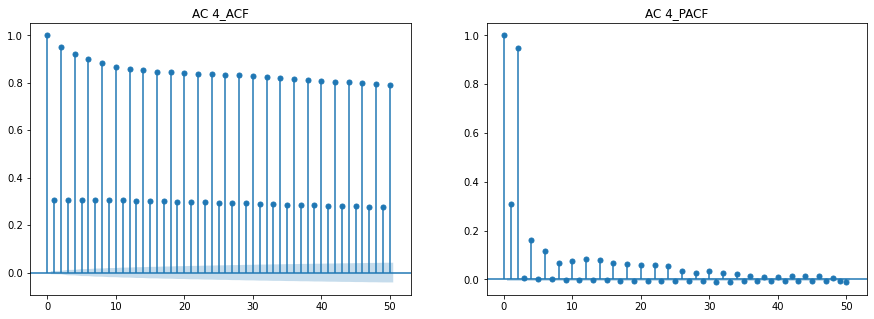

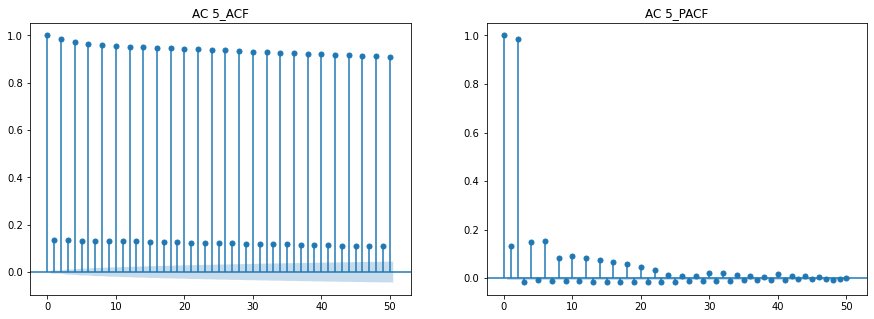

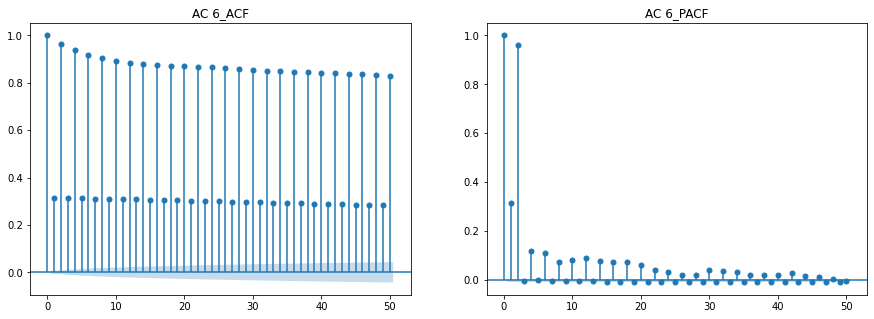

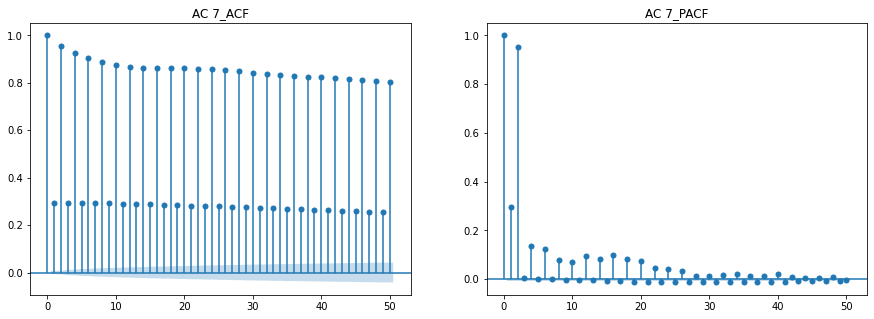

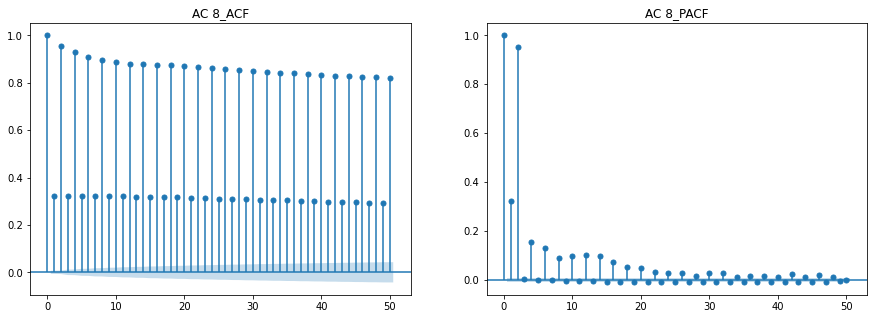

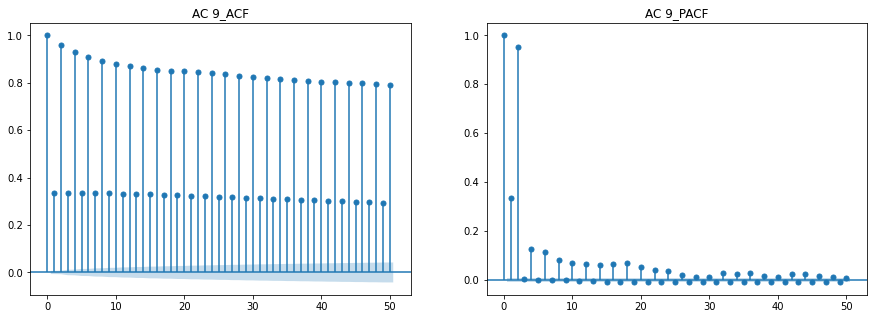

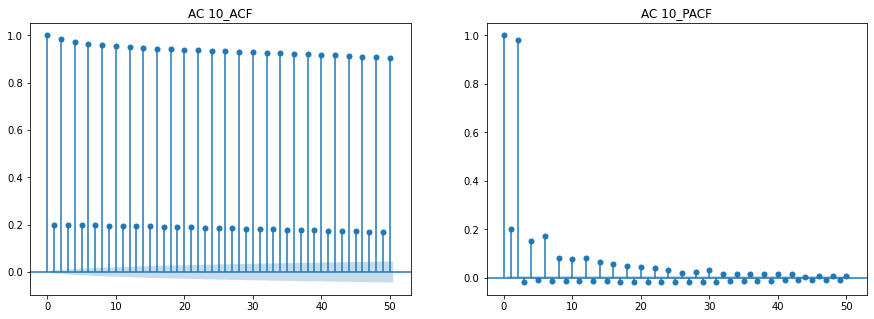

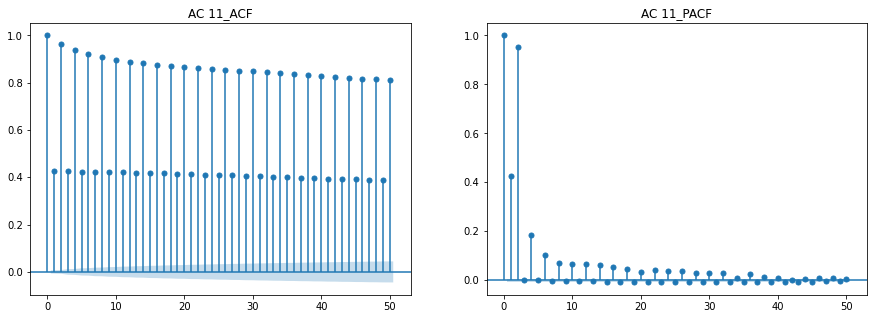

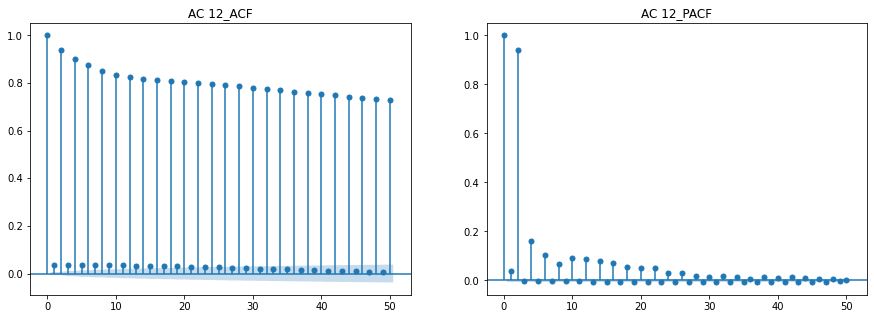

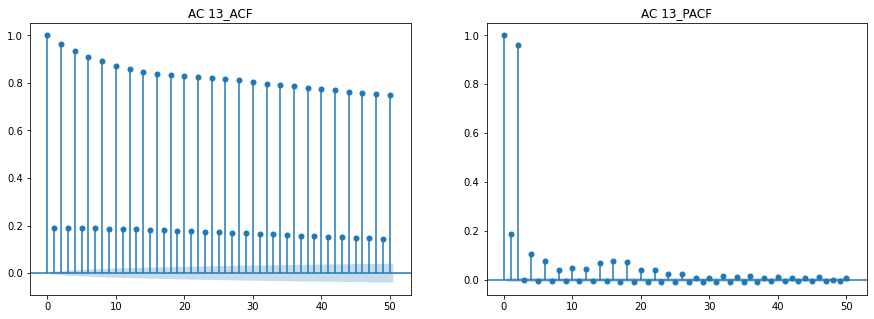

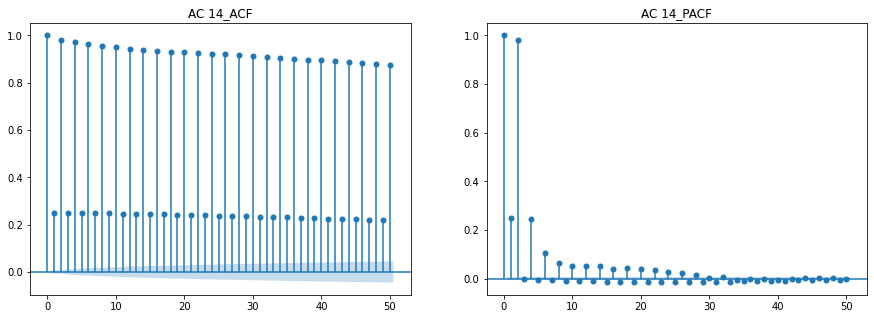

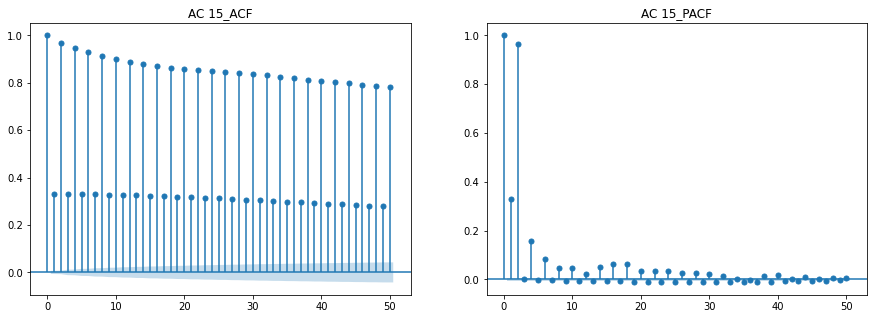

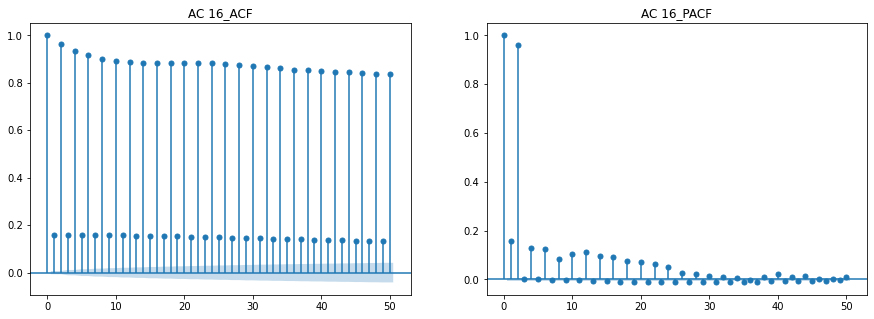

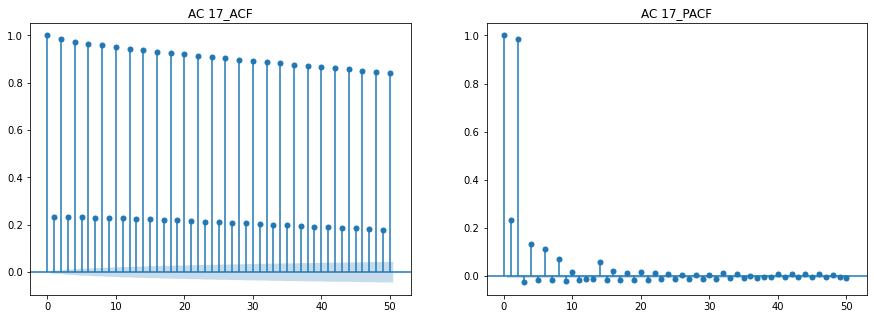

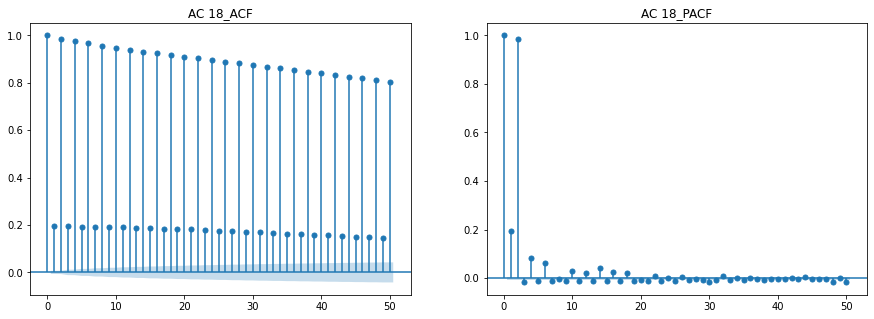

In [64]:
for i in final.columns:

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

    plot_acf(final[i], ax = axes[0], title = f"{i}_ACF");
#     ax.set_title(f'{i}' + " ACF")
    plot_pacf(final[i], ax = axes[1], title = f"{i}_PACF");
#     ax.set_title(f'{i}' + " PACF")

# Train Test Split
**Will try to forecast next 120 observations ,i.e., next two hour power consumption**

In [65]:
final.iloc[:-120, :].shape

(87720, 18)

In [66]:
final.iloc[-120:, :].shape

(120, 18)

In [67]:
train = final.iloc[:-120, :]
test = final.iloc[-120:, :]

In [68]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# VAR
**Reason to use this is that considering that AC's are not in room but in dinning halls, Canteen or other places ,i.e., the power consumption of one AC can be dependent on another<br>
Hence, the assumption that we making here is that the future valeus of a time series are dependent on its own past values and also one the past values of other time series**

In [69]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [70]:
model = VAR(endog=train)
model_fit = model.fit(5)

In [71]:
results = model_fit.forecast(model_fit.y, steps=len(test))

In [72]:
df_forecast = pd.DataFrame(results, columns=test.columns, index = test.index)

In [73]:
df_forecast[df_forecast< 0] = 0

In [74]:
lst = []
for i in test.columns:
    error = mape(test[i], df_forecast[i])
    print(f"{i} ----> {error}")
    lst.append(error)

AC 1 ----> 16.264541144933933
AC 2 ----> 24.737789920381108
AC 3 ----> 28.130192177925434
AC 4 ----> inf
AC 5 ----> 107.88432942135913
AC 6 ----> inf
AC 7 ----> 34.1937040531905
AC 8 ----> inf
AC 9 ----> 37.86925505833667
AC 10 ----> 32.00390614542355
AC 11 ----> 39.66144753601134
AC 12 ----> 24.760972218774974
AC 13 ----> 15.345945984958146
AC 14 ----> 14.369340910287889
AC 15 ----> 15.812943949314729
AC 16 ----> 38.794628325731914
AC 17 ----> 16.496647083199488
AC 18 ----> 20.7277268162987


**That value "inf" is due to division by zero, it is one of the drawback of using MAPE which occurs when Actual Value is 0, but I have used it here as it is one of the most common metric used in case of the evaluation of time series data**

In [75]:
test["AC 4"] += 1
test["AC 6"] += 1
test["AC 8"] += 1

In [76]:
df_forecast["AC 4"] += 1
df_forecast["AC 6"] += 1
df_forecast["AC 8"] += 1

**Here I have used very simple way to deal with division by zero error :)**

In [77]:
for i in ["AC 4", "AC 6", "AC 8"]:
    error = mape(test[i], df_forecast[i])
    print(f"{i} ----> {error}")

AC 4 ----> 54.76864582785128
AC 6 ----> 51.86004980754869
AC 8 ----> 45.291912256736175


# Facebook Prophet
**Facebook Prophet is used in Univariate time series only, I am using this with the assumption that all the AC's power consumption is independent of each other like they are Room AC's**

**FbProphet Shows irrelevant warnings in Kaggle, so it has been implemented separately in another Notebook**